In [ ]:
# Spark setup

# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [ ]:
!pip install pyspark -q

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 42.7 MB/s 


In [ ]:
# starts the spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
spark

In [ ]:
!unzip "/content/drive/MyDrive/CRWK_BD/archive_IDS2018.zip"

Archive:  /content/drive/MyDrive/CRWK_BD/archive_IDS2018.zip
 extracting: archive_IDS2018/02-14-2018.csv  
 extracting: archive_IDS2018/02-15-2018.csv  
 extracting: archive_IDS2018/02-16-2018.csv  
 extracting: archive_IDS2018/02-21-2018.csv  
 extracting: archive_IDS2018/02-22-2018.csv  
 extracting: archive_IDS2018/02-23-2018.csv  
 extracting: archive_IDS2018/03-02-2018.csv  


In [ ]:

data1=spark.read.csv('/content/archive_IDS2018/02-14-2018.csv',inferSchema=True,header=True)
data2=spark.read.csv('/content/archive_IDS2018/02-15-2018.csv',inferSchema=True,header=True)
data3=spark.read.csv('/content/archive_IDS2018/02-16-2018.csv',inferSchema=True,header=True)
data4=spark.read.csv('/content/archive_IDS2018/02-21-2018.csv',inferSchema=True,header=True)
data5=spark.read.csv('/content/archive_IDS2018/02-22-2018.csv',inferSchema=True,header=True)
data6=spark.read.csv('/content/archive_IDS2018/02-23-2018.csv',inferSchema=True,header=True)
#data7=spark.read.csv('/content/archive_IDS2018/02-28-2018.csv',inferSchema=True,header=True)
#data8=spark.read.csv('/content/archive_IDS2018/03-01-2018.csv',inferSchema=True,header=True)
#data9=spark.read.csv('/content/archive_IDS2018/03-02-2018.csv',inferSchema=True,header=True)






In [ ]:
from functools import reduce

bddata=reduce(lambda x,y:x.union(y), [data1,data2,data3,data4,data5,data6])

In [ ]:

bddata.printSchema()

In [ ]:
bddata.show(4)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+--------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----

In [ ]:
bddata.count()

6291444

In [ ]:
#bddata.describe().show()

Finding/checking the null values


In [ ]:
#from pyspark.sql import functions as F
#bddata.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in bddata.columns]).show()

In [ ]:
from pyspark.sql import functions as F
bddata.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in bddata.columns]).show()

+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-

In [ ]:
bddata.groupby('Label').count().toPandas()

,Label,count
0,SSH-Bruteforce,187589
1,SQL Injection,87
2,DoS attacks-Slowloris,10990
3,Benign,4567525
4,DoS attacks-SlowHTTPTest,139890
5,DoS attacks-GoldenEye,41508
6,Brute Force -XSS,230
7,FTP-BruteForce,193360
8,DDOS attack-LOIC-UDP,1730
9,DoS attacks-Hulk,461912


Categorical and Numerical column

In [ ]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in bddata.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in bddata.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(cat_cols)) + '  categorical features')
print(str(len(num_cols)) + '  numerical features')

2  categorical features
69  numerical features


In [ ]:
cat_cols

['Timestamp', 'Label']

In [ ]:
bddata=bddata.drop('Timestamp')

bddata=bddata.drop('Flow Byts/s')


In [ ]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in bddata.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in bddata.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(cat_cols)) + '  categorical features')
print(str(len(num_cols)) + '  numerical features')

cat_cols

1  categorical features
68  numerical features


['Label']

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
from pyspark.ml import feature
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

In [ ]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert #aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector #and the rest of numerical features into a 
# single vector column. we append every step of the process in a #stages array
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [ ]:
from pyspark.ml import Pipeline
cols = bddata.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(bddata)
df2 = pipelineModel.transform(bddata)

In [ ]:
selectedCols = ['features']+cols
df2 = df2.select(selectedCols)

In [ ]:
# New dataset after feature engineering:
import pandas as pd

pd.DataFrame(df2.take(2), columns=df2.columns)

,features,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,112641719,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.026633,56320859.5,139.300036,56320958,56320761,112641719,56320859.5,139.300036,56320958,56320761,0,0.0,0.0,0,0,0,0,0,0,0,0,0.026633,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,112641466,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.026633,56320733.0,114.551299,56320814,56320652,112641466,56320733.0,114.551299,56320814,56320652,0,0.0,0.0,0,0,0,0,0,0,0,0,0.026633,0.0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign


In [ ]:
df2.dtypes

[('features', 'vector'),
 ('Dst Port', 'int'),
 ('Protocol', 'int'),
 ('Flow Duration', 'bigint'),
 ('Tot Fwd Pkts', 'int'),
 ('Tot Bwd Pkts', 'int'),
 ('TotLen Fwd Pkts', 'int'),
 ('TotLen Bwd Pkts', 'int'),
 ('Fwd Pkt Len Max', 'int'),
 ('Fwd Pkt Len Min', 'int'),
 ('Fwd Pkt Len Mean', 'double'),
 ('Fwd Pkt Len Std', 'double'),
 ('Bwd Pkt Len Max', 'int'),
 ('Bwd Pkt Len Min', 'int'),
 ('Bwd Pkt Len Mean', 'double'),
 ('Bwd Pkt Len Std', 'double'),
 ('Flow Pkts/s', 'double'),
 ('Flow IAT Mean', 'double'),
 ('Flow IAT Std', 'double'),
 ('Flow IAT Max', 'bigint'),
 ('Flow IAT Min', 'bigint'),
 ('Fwd IAT Tot', 'bigint'),
 ('Fwd IAT Mean', 'double'),
 ('Fwd IAT Std', 'double'),
 ('Fwd IAT Max', 'bigint'),
 ('Fwd IAT Min', 'bigint'),
 ('Bwd IAT Tot', 'int'),
 ('Bwd IAT Mean', 'double'),
 ('Bwd IAT Std', 'double'),
 ('Bwd IAT Max', 'int'),
 ('Bwd IAT Min', 'int'),
 ('Fwd PSH Flags', 'int'),
 ('Bwd PSH Flags', 'int'),
 ('Fwd URG Flags', 'int'),
 ('Bwd URG Flags', 'int'),
 ('Fwd Header Len',

In [ ]:
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="Label", outputCol="labelIndex")
newdf = l_indexer.fit(df2).transform(df2)
newdf.show(4)

+--------------------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-

In [ ]:
# Train/Test Split
splits = [.75, .25]
train_data, test_data = newdf.randomSplit(splits)

In [ ]:
forest_model = RandomForestClassifier(featuresCol='features', labelCol='labelIndex', 
                            predictionCol='prediction', maxDepth=30, 
                            impurity='gini', subsamplingRate= .5).fit(train_data)

In [ ]:
predictions = forest_model.transform(test_data).select('labelIndex', 'prediction')

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='labelIndex')

In [ ]:
# inspect F1 and accuracy scores
print('F1 Score:',evaluator.evaluate(predictions,{evaluator.metricName: 'f1'}))
print('Accuracy:',evaluator.evaluate(predictions,{evaluator.metricName: 'accuracy'}))

F1 Score: 0.9999917025498746
F1 Score: 0.9999917025498746
Accuracy: 0.999991730890087
Accuracy: 0.999991730890087


In [ ]:
# Inspect feature importance
sorted(list(zip(forest_model.featureImportances,features)),reverse=True)

In [ ]:
import six

for i in newdf.select(num_cols_NewDF).columns:
    if not( isinstance(newdf.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Label for ", i, newdf.stat.corr('labelIndex',i))

# **Correlation and Graph**

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import expr , when , lit , col

bddata.filter(col("Flow Byts/s").isNotNull())

l_indexer = StringIndexer(inputCol="Label", outputCol="labelIndex")
bddata = l_indexer.fit(bddata).transform(bddata)

bddata=bddata.drop('Label')

assembler = VectorAssembler(inputCols=bddata.columns, 
outputCol="features",handleInvalid='keep')
df = assembler.transform(bddata).select("features")

# correlation will be in Dense Matrix
correlation = Correlation.corr(df,"features","pearson").collect()[0][0]

# To convert Dense Matrix into DataFrame
rows = correlation.toArray().tolist()
df = spark.createDataFrame(rows,bddata.columns)

In [ ]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+

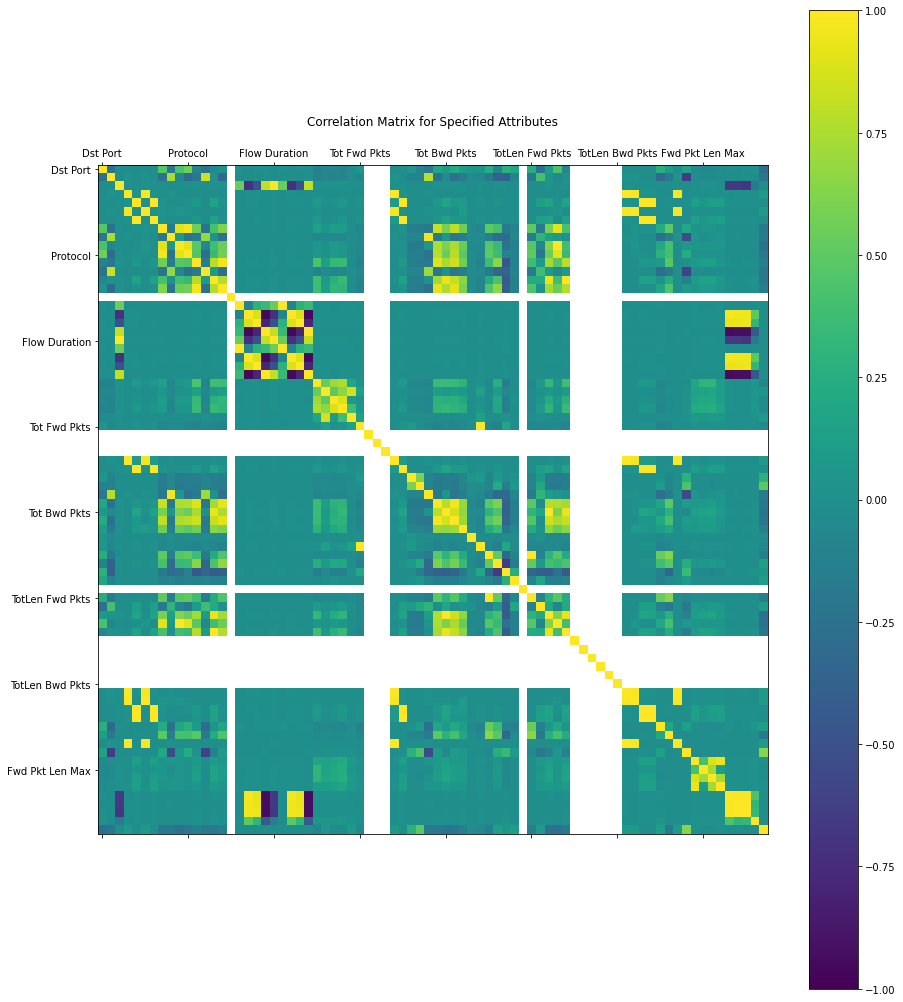

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=[15,18]

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    #plt.figure(figsize=(40,20))
    plt.show()

plot_corr_matrix(rows, bddata.columns, 444)

# **Stastical analysis method-2**

In [ ]:
seriesX = sc.parallelize([1.0, 2.0, 3.0, 3.0, 5.0])  # a series
# seriesY must have the same number of partitions and cardinality as seriesX
seriesY = sc.parallelize([11.0, 22.0, 33.0, 33.0, 555.0])

# Compute the correlation using Pearson's method. Enter "spearman" for Spearman's method.
# If a method is not specified, Pearson's method will be used by default.
print("Correlation is: " + str(Statistics.corr(seriesX, seriesY, method="pearson")))

NameError: ignored

In [ ]:
pandas_df = df.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

#Using Pearson Correlation
plt.figure(figsize=(20,20))
#cor = df4.corr()
sns.heatmap(rows, annot=True, cmap=plt.cm.Reds)
plt.show()



In [ ]:

df.createOrReplaceTempView("crView") 
crdF = spark.sql("SELECT * FROM crView") 
crdF.show(4)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+

In [ ]:
crdF = spark.sql("SELECT labelIndex from crView ") 
crdF.show()


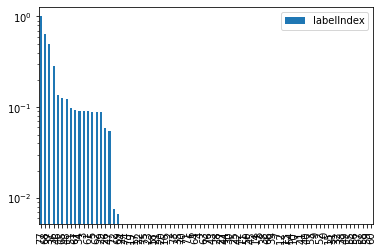

In [ ]:
pandas_df = crdF.toPandas()
pandas_df.sort_values(by='labelIndex',ascending=False).plot( y='labelIndex', kind = 'bar',logy=True)


In [ ]:
from pyspark.sql.functions import col, countDistinct

newdf.agg(countDistinct(col("labelIndex")).alias("count")).show()
newdf.groupBy("labelIndex").count().show()

+-----+
|count|
+-----+
|   12|
+-----+

+----------+-------+
|labelIndex|  count|
+----------+-------+
|       8.0|   1730|
|       0.0|4567525|
|       7.0|  10990|
|       1.0| 686012|
|       4.0| 187589|
|      11.0|     87|
|       3.0| 193360|
|       2.0| 461912|
|      10.0|    230|
|       6.0|  41508|
|       5.0| 139890|
|       9.0|    611|
+----------+-------+



In [ ]:
df.count()

NameError: ignored

In [ ]:
bddata.groupBy("Label").count().show()

+--------------------+-------+
|               Label|  count|
+--------------------+-------+
|      SSH-Bruteforce| 187589|
|       SQL Injection|     87|
|DoS attacks-Slowl...|  10990|
|              Benign|4567525|
|DoS attacks-SlowH...| 139890|
|DoS attacks-Golde...|  41508|
|    Brute Force -XSS|    230|
|      FTP-BruteForce| 193360|
|DDOS attack-LOIC-UDP|   1730|
|    DoS attacks-Hulk| 461912|
|    Brute Force -Web|    611|
|    DDOS attack-HOIC| 686012|
+--------------------+-------+



In [ ]:
(trainingData, testData) = newdf.randomSplit([0.7, 0.3])
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")
model = dt.fit(trainingData)

In [ ]:
predictions = model.transform(testData)
predictions.select("prediction", "labelIndex", "features").show(5)

+----------+----------+--------------------+
|prediction|labelIndex|            features|
+----------+----------+--------------------+
|       0.0|       0.0|(79,[0,11,12,13,1...|
|       0.0|       0.0|(79,[0,11,12,13,1...|
|       0.0|       0.0|(79,[0,11,12,13,1...|
|       0.0|       0.0|(79,[0,11,12,13,1...|
|       0.0|       0.0|(79,[0,11,12,13,1...|
+----------+----------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex",
predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy =", accuracy)
print("Test Error = %g " % (1.0 - accuracy))
print(model)

accuracy = 0.9912674810591516
Test Error = 0.00873252 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8527c3ee5042, depth=5, numNodes=11, numClasses=12, numFeatures=79


# **NaiveBayes**

In [ ]:
from pyspark.sql import functions as F
newdf.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in newdf.columns]).show()

+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------+--

In [ ]:
from pyspark.sql import functions as F
bddata.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in bddata.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------+----------+

In [ ]:
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="Label", outputCol="labelIndex")
nvdata = l_indexer.fit(bddata).transform(bddata)
nvdata.show(4)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----

In [ ]:
nvdata=nvdata.drop('Label')

nvdata.show(4)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----

In [ ]:
splits = nvdata.randomSplit([0.7, 0.3], 1234)
train = splits[0]
test = splits[1]

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0,modelType="multinomial")
model = nb.fit(train)

IllegalArgumentException: ignored

# ***SQL Quries part***

In [ ]:
!pip3 install pyspark -q

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 55.8 MB/s 


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
.appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [ ]:
!unzip "/content/drive/MyDrive/CRWK_BD/archive_IDS2018.zip"

Archive:  /content/drive/MyDrive/CRWK_BD/archive_IDS2018.zip
 extracting: archive_IDS2018/02-14-2018.csv  
 extracting: archive_IDS2018/02-15-2018.csv  
 extracting: archive_IDS2018/02-16-2018.csv  
 extracting: archive_IDS2018/02-21-2018.csv  
 extracting: archive_IDS2018/02-22-2018.csv  
 extracting: archive_IDS2018/02-23-2018.csv  
 extracting: archive_IDS2018/03-02-2018.csv  


In [ ]:

data1=spark.read.csv('/content/archive_IDS2018/02-14-2018.csv',inferSchema=True,header=True)
data2=spark.read.csv('/content/archive_IDS2018/02-15-2018.csv',inferSchema=True,header=True)
data3=spark.read.csv('/content/archive_IDS2018/02-16-2018.csv',inferSchema=True,header=True)
data4=spark.read.csv('/content/archive_IDS2018/02-21-2018.csv',inferSchema=True,header=True)
data5=spark.read.csv('/content/archive_IDS2018/02-22-2018.csv',inferSchema=True,header=True)
data6=spark.read.csv('/content/archive_IDS2018/02-23-2018.csv',inferSchema=True,header=True)
#data7=spark.read.csv('/content/archive_IDS2018/03-02-2018.csv',inferSchema=True,header=True)


In [ ]:
from functools import reduce

bdsql=reduce(lambda x,y:x.union(y), [data1,data2,data3,data4,data5,data6])

In [ ]:
type(bdsql)

pyspark.sql.dataframe.DataFrame

In [ ]:
bdsql.printSchema()

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: long (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: integer (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: long (nullable = true)
 |-- Flow IAT Min: long (nullable = true)
 |

In [ ]:
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import unix_timestamp
df_conv=bdsql.withColumn("Timestamp",unix_timestamp("Timestamp", 'dd/MM/yyyy HH:mm:ss').cast(TimestampType()))

df_conv.printSchema()
df_conv.show(5)

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Flow Duration: long (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: integer (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: long (nullable = true)
 |-- Flow IAT Min: long (nullable = true)

In [ ]:
from pyspark.sql.functions import *
df_conv = (df_conv.select("Timestamp","Label").withColumn("weekofyear", weekofyear("Timestamp")))
df_conv.show(4)

+-------------------+------+----------+
|          Timestamp| Label|weekofyear|
+-------------------+------+----------+
|2018-02-14 08:31:01|Benign|         7|
|2018-02-14 08:33:50|Benign|         7|
|2018-02-14 08:36:39|Benign|         7|
|2018-02-14 08:40:13|Benign|         7|
+-------------------+------+----------+
only showing top 4 rows



In [ ]:
df_conv.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Label: string (nullable = true)
 |-- weekofyear: integer (nullable = true)



In [ ]:
df_conv = (df_conv.select("Timestamp","Label","weekofyear").withColumn("month", month("Timestamp")))
df_conv.show(4)

+-------------------+------+----------+-----+
|          Timestamp| Label|weekofyear|month|
+-------------------+------+----------+-----+
|2018-02-14 08:31:01|Benign|         7|    2|
|2018-02-14 08:33:50|Benign|         7|    2|
|2018-02-14 08:36:39|Benign|         7|    2|
|2018-02-14 08:40:13|Benign|         7|    2|
+-------------------+------+----------+-----+
only showing top 4 rows



In [ ]:
df_conv = (df_conv.select("Timestamp","Label","weekofyear").withColumn("Day", dayofmonth("Timestamp")))

df_conv.show(2)

+-------------------+------+----------+---+
|          Timestamp| Label|weekofyear|Day|
+-------------------+------+----------+---+
|2018-02-14 08:31:01|Benign|         7| 14|
|2018-02-14 08:33:50|Benign|         7| 14|
+-------------------+------+----------+---+
only showing top 2 rows



In [ ]:
#df_conv2 = (df_conv.select("Timestamp","Label","weekofyear","month").withColumn("date", to_date("Timestamp")))
#df_conv2.show(4)

from pyspark.sql.functions import date_format

df1=df_conv.withColumn("DateOnly", date_format(unix_timestamp("Timestamp").cast(TimestampType()), "yyyy-MM-dd"))
df1.show(2)

+-------------------+----------+----------+
|          Timestamp|      date|  DateOnly|
+-------------------+----------+----------+
|2018-02-14 08:31:01|2018-02-14|2018-02-14|
|2018-02-14 08:33:50|2018-02-14|2018-02-14|
+-------------------+----------+----------+
only showing top 2 rows



In [ ]:
# importing window from pyspark.sql.window
from pyspark.sql.window import Window

# importing aggregate functions
# from pyspark.sql.functions
from pyspark.sql.functions import col,avg,sum,min,max,row_number

# creating a window partition of dataframe
windowPartitionAgg = Window.partitionBy("Department")

# applying window aggregate function
# to df3 with the help of withColumn

# this is average()
df3.withColumn("Sum", sum(col("salary")).over(windowPartitionAgg)).withColumn("Avg",avg(col("salary")).over(windowPartitionAgg)).withColumn("Min",	min(col("salary")).over(windowPartitionAgg)).withColumn("Max",	max(col("salary")).over(windowPartitionAgg)).show()

	  #this is sum()
    #
	   #this is min()
   
	  #this is max()
   

In [ ]:
df_conv.groupBy('Label').count().orderBy('count', ascending=False)
df_conv.show(4)

+-------------------+------+----------+-----+
|          Timestamp| Label|weekofyear|month|
+-------------------+------+----------+-----+
|2018-02-14 08:31:01|Benign|         7|    2|
|2018-02-14 08:33:50|Benign|         7|    2|
|2018-02-14 08:36:39|Benign|         7|    2|
|2018-02-14 08:40:13|Benign|         7|    2|
+-------------------+------+----------+-----+
only showing top 4 rows



In [ ]:
df_conv.groupby(['weekofyear','Label','Day'])
df_conv.show(4)

+-------------------+------+----------+---+
|          Timestamp| Label|weekofyear|Day|
+-------------------+------+----------+---+
|2018-02-14 08:31:01|Benign|         7| 14|
|2018-02-14 08:33:50|Benign|         7| 14|
|2018-02-14 08:36:39|Benign|         7| 14|
|2018-02-14 08:40:13|Benign|         7| 14|
+-------------------+------+----------+---+
only showing top 4 rows



In [ ]:
df_conv.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Label: string (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- Day: integer (nullable = true)



In [ ]:
df_conv.show(5)

+-------------------+------+----------+---+
|          Timestamp| Label|weekofyear|Day|
+-------------------+------+----------+---+
|2018-02-14 08:31:01|Benign|         7| 14|
|2018-02-14 08:33:50|Benign|         7| 14|
|2018-02-14 08:36:39|Benign|         7| 14|
|2018-02-14 08:40:13|Benign|         7| 14|
|2018-02-14 08:40:23|Benign|         7| 14|
+-------------------+------+----------+---+
only showing top 5 rows



In [ ]:

df_conv.groupBy("Label", "weekofyear").agg(count("*").alias("cnt")).show()

+--------------------+----------+-------+
|               Label|weekofyear|    cnt|
+--------------------+----------+-------+
|              Benign|         7|2110468|
|              Benign|         3|      8|
|              Benign|         2|      6|
|      FTP-BruteForce|         7| 193360|
|      SSH-Bruteforce|         7| 187589|
|DoS attacks-Golde...|         7|  41508|
|DoS attacks-Slowl...|         7|  10990|
|DoS attacks-SlowH...|         7| 139890|
|    DoS attacks-Hulk|         7| 461912|
|    DDOS attack-HOIC|         8| 686012|
|DDOS attack-LOIC-UDP|         8|   1730|
|              Benign|         8|2457043|
|    Brute Force -XSS|         8|    230|
|    Brute Force -Web|         8|    611|
|       SQL Injection|         8|     87|
+--------------------+----------+-------+



In [ ]:

df_conv.groupBy("Day","Label", "weekofyear").agg(count("*").alias("cnt")).show()

+---+--------------------+----------+-------+
|Day|               Label|weekofyear|    cnt|
+---+--------------------+----------+-------+
| 12|              Benign|         3|      8|
| 14|      SSH-Bruteforce|         7| 187589|
|  5|              Benign|         2|      1|
| 14|      FTP-BruteForce|         7| 193360|
|  8|              Benign|         2|      1|
| 14|              Benign|         7| 667621|
| 15|              Benign|         7| 996076|
| 15|DoS attacks-Slowl...|         7|  10990|
| 15|DoS attacks-Golde...|         7|  41508|
| 16|DoS attacks-SlowH...|         7| 139890|
| 16|    DoS attacks-Hulk|         7| 461912|
| 16|              Benign|         7| 446771|
| 21|    DDOS attack-HOIC|         8| 686012|
| 21|DDOS attack-LOIC-UDP|         8|   1730|
| 21|              Benign|         8| 360832|
| 10|              Benign|         2|      1|
| 22|              Benign|         8|1048203|
| 11|              Benign|         2|      3|
| 22|    Brute Force -XSS|        

In [ ]:
# Counts the number of distinct rows in dataframe
df_conv.distinct().count()

155260

In [ ]:
df_conv.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Label: string (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- month: integer (nullable = true)



In [ ]:
df_conv.groupBy("Label", "weekofyear").agg(count("*")).show()

+--------------------+----------+--------+
|               Label|weekofyear|count(1)|
+--------------------+----------+--------+
|              Benign|         7| 2110468|
|              Benign|         3|       8|
|              Benign|         2|       6|
|      FTP-BruteForce|         7|  193360|
|      SSH-Bruteforce|         7|  187589|
|DoS attacks-Golde...|         7|   41508|
|DoS attacks-Slowl...|         7|   10990|
|DoS attacks-SlowH...|         7|  139890|
|    DoS attacks-Hulk|         7|  461912|
|    DDOS attack-HOIC|         8|  686012|
|DDOS attack-LOIC-UDP|         8|    1730|
|              Benign|         8| 2457043|
|    Brute Force -XSS|         8|     230|
|    Brute Force -Web|         8|     611|
|       SQL Injection|         8|      87|
+--------------------+----------+--------+



In [ ]:
df_conv.groupBy("weekofyear","Label").agg(count("*")).show()

+----------+--------------------+--------+
|weekofyear|               Label|count(1)|
+----------+--------------------+--------+
|         7|      FTP-BruteForce|  193360|
|         7|              Benign| 2110468|
|         2|              Benign|       6|
|         3|              Benign|       8|
|         7|      SSH-Bruteforce|  187589|
|         7|DoS attacks-Slowl...|   10990|
|         7|DoS attacks-Golde...|   41508|
|         7|DoS attacks-SlowH...|  139890|
|         7|    DoS attacks-Hulk|  461912|
|         8|              Benign| 2457043|
|         8|    DDOS attack-HOIC|  686012|
|         8|DDOS attack-LOIC-UDP|    1730|
|         8|       SQL Injection|      87|
|         8|    Brute Force -Web|     611|
|         8|    Brute Force -XSS|     230|
+----------+--------------------+--------+



In [ ]:
df_conv.groupBy("weekofyear","Day","Label").agg(count("*")).show(100, False)

+----------+---+------------------------+--------+
|weekofyear|Day|Label                   |count(1)|
+----------+---+------------------------+--------+
|7         |14 |Benign                  |667621  |
|3         |12 |Benign                  |8       |
|2         |5  |Benign                  |1       |
|7         |14 |FTP-BruteForce          |193360  |
|7         |14 |SSH-Bruteforce          |187589  |
|2         |8  |Benign                  |1       |
|7         |15 |DoS attacks-Slowloris   |10990   |
|7         |15 |DoS attacks-GoldenEye   |41508   |
|7         |15 |Benign                  |996076  |
|7         |16 |DoS attacks-Hulk        |461912  |
|7         |16 |Benign                  |446771  |
|7         |16 |DoS attacks-SlowHTTPTest|139890  |
|8         |21 |DDOS attack-HOIC        |686012  |
|8         |21 |DDOS attack-LOIC-UDP    |1730    |
|8         |21 |Benign                  |360832  |
|2         |10 |Benign                  |1       |
|2         |11 |Benign         

In [ ]:
#df_conv['month'].distinct()

df_conv.select('Day').distinct().show(100, False)

+---+
|Day|
+---+
|12 |
|5  |
|8  |
|14 |
|15 |
|16 |
|21 |
|22 |
|10 |
|11 |
|23 |
+---+



In [ ]:

df_conv.select('weekofyear').distinct().show(100, False)

+----------+
|weekofyear|
+----------+
|3         |
|7         |
|2         |
|8         |
+----------+



In [ ]:
df_conv.groupBy("weekofyear","Day").agg(count("*")).show(100, False)

+----------+---+--------+
|weekofyear|Day|count(1)|
+----------+---+--------+
|7         |14 |1048570 |
|2         |5  |1       |
|3         |12 |8       |
|2         |8  |1       |
|7         |15 |1048574 |
|7         |16 |1048573 |
|8         |21 |1048574 |
|2         |11 |3       |
|2         |10 |1       |
|8         |22 |1048565 |
|8         |23 |1048574 |
+----------+---+--------+



In [ ]:
df_conv.groupBy("weekofyear").agg(count("*")).show(100, False)

+----------+--------+
|weekofyear|count(1)|
+----------+--------+
|3         |8       |
|7         |3145717 |
|2         |6       |
|8         |3145713 |
+----------+--------+



In [ ]:
df_conv.groupBy("weekofyear").pivot("Day").count().orderBy("weekofyear",ascending=False).show()

+----------+----+----+----+----+----+-------+-------+-------+-------+-------+-------+
|weekofyear|   5|   8|  10|  11|  12|     14|     15|     16|     21|     22|     23|
+----------+----+----+----+----+----+-------+-------+-------+-------+-------+-------+
|         8|null|null|null|null|null|   null|   null|   null|1048574|1048565|1048574|
|         7|null|null|null|null|null|1048570|1048574|1048573|   null|   null|   null|
|         3|null|null|null|null|   8|   null|   null|   null|   null|   null|   null|
|         2|   1|   1|   1|   3|null|   null|   null|   null|   null|   null|   null|
+----------+----+----+----+----+----+-------+-------+-------+-------+-------+-------+



In [ ]:
df_conv.groupBy("Day").pivot("Label").count().orderBy("Day",ascending=False).show(100,False)

+---+-------+----------------+----------------+----------------+--------------------+---------------------+----------------+------------------------+---------------------+--------------+-------------+--------------+
|Day|Benign |Brute Force -Web|Brute Force -XSS|DDOS attack-HOIC|DDOS attack-LOIC-UDP|DoS attacks-GoldenEye|DoS attacks-Hulk|DoS attacks-SlowHTTPTest|DoS attacks-Slowloris|FTP-BruteForce|SQL Injection|SSH-Bruteforce|
+---+-------+----------------+----------------+----------------+--------------------+---------------------+----------------+------------------------+---------------------+--------------+-------------+--------------+
|23 |1048008|362             |151             |null            |null                |null                 |null            |null                    |null                 |null          |53           |null          |
|22 |1048203|249             |79              |null            |null                |null                 |null            |null        

In [ ]:
df_conv.groupBy("weekofyear").pivot("Label").count().orderBy("weekofyear",ascending=False).show(100,False)

+----------+-------+----------------+----------------+----------------+--------------------+---------------------+----------------+------------------------+---------------------+--------------+-------------+--------------+
|weekofyear|Benign |Brute Force -Web|Brute Force -XSS|DDOS attack-HOIC|DDOS attack-LOIC-UDP|DoS attacks-GoldenEye|DoS attacks-Hulk|DoS attacks-SlowHTTPTest|DoS attacks-Slowloris|FTP-BruteForce|SQL Injection|SSH-Bruteforce|
+----------+-------+----------------+----------------+----------------+--------------------+---------------------+----------------+------------------------+---------------------+--------------+-------------+--------------+
|8         |2457043|611             |230             |686012          |1730                |null                 |null            |null                    |null                 |null          |87           |null          |
|7         |2110468|null            |null            |null            |null                |41508           

In [ ]:
df_conv.groupBy("Label").pivot("weekofyear").count().orderBy("Label",ascending=False).show(100,False)

+------------------------+----+----+-------+-------+
|Label                   |2   |3   |7      |8      |
+------------------------+----+----+-------+-------+
|SSH-Bruteforce          |null|null|187589 |null   |
|SQL Injection           |null|null|null   |87     |
|FTP-BruteForce          |null|null|193360 |null   |
|DoS attacks-Slowloris   |null|null|10990  |null   |
|DoS attacks-SlowHTTPTest|null|null|139890 |null   |
|DoS attacks-Hulk        |null|null|461912 |null   |
|DoS attacks-GoldenEye   |null|null|41508  |null   |
|DDOS attack-LOIC-UDP    |null|null|null   |1730   |
|DDOS attack-HOIC        |null|null|null   |686012 |
|Brute Force -XSS        |null|null|null   |230    |
|Brute Force -Web        |null|null|null   |611    |
|Benign                  |6   |8   |2110468|2457043|
+------------------------+----+----+-------+-------+



In [ ]:
df_conv.groupBy("Label").pivot("Day").count().orderBy("Label",ascending=False).show(100,False)

+------------------------+----+----+----+----+----+------+------+------+------+-------+-------+
|Label                   |5   |8   |10  |11  |12  |14    |15    |16    |21    |22     |23     |
+------------------------+----+----+----+----+----+------+------+------+------+-------+-------+
|SSH-Bruteforce          |null|null|null|null|null|187589|null  |null  |null  |null   |null   |
|SQL Injection           |null|null|null|null|null|null  |null  |null  |null  |34     |53     |
|FTP-BruteForce          |null|null|null|null|null|193360|null  |null  |null  |null   |null   |
|DoS attacks-Slowloris   |null|null|null|null|null|null  |10990 |null  |null  |null   |null   |
|DoS attacks-SlowHTTPTest|null|null|null|null|null|null  |null  |139890|null  |null   |null   |
|DoS attacks-Hulk        |null|null|null|null|null|null  |null  |461912|null  |null   |null   |
|DoS attacks-GoldenEye   |null|null|null|null|null|null  |41508 |null  |null  |null   |null   |
|DDOS attack-LOIC-UDP    |null|null|null

In [ ]:
df_conv.groupBy("Label").pivot("Day").count().orderBy("Label",ascending=False).show(100,False)

"""
df_conv.groupBy("Day").pivot("Label").count().orderBy("Day",ascending=False).show(100,False)

import pyspark.sql.functions as F

col_list = ["Benign","Brute Force -Web","Brute Force -XSS","DDOS attack-HOIC","DDOS attack-LOIC-UDP","DoS attacks-GoldenEye","DoS attacks-Hulk","DoS attacks-SlowHTTPTest","DoS attacks-Slowloris","FTP-BruteForce","SQL Injection","SSH-Bruteforce"]
# or col_list = df.columns[16:20]

df2 = df_conv.withColumn('SUM1',sum(F.udf(col(c) for c in col_list)))

df2.show()

#df_conv.groupBy("Label").pivot("Day").count().orderBy("Label",ascending=False).withColumn('accumulating_sum',F.sum('Day'))

#sum(cast(Label#95 as double)) AS accumulating_sum#21337]

"""

+------------------------+----+----+----+----+----+------+------+------+------+-------+-------+
|Label                   |5   |8   |10  |11  |12  |14    |15    |16    |21    |22     |23     |
+------------------------+----+----+----+----+----+------+------+------+------+-------+-------+
|SSH-Bruteforce          |null|null|null|null|null|187589|null  |null  |null  |null   |null   |
|SQL Injection           |null|null|null|null|null|null  |null  |null  |null  |34     |53     |
|FTP-BruteForce          |null|null|null|null|null|193360|null  |null  |null  |null   |null   |
|DoS attacks-Slowloris   |null|null|null|null|null|null  |10990 |null  |null  |null   |null   |
|DoS attacks-SlowHTTPTest|null|null|null|null|null|null  |null  |139890|null  |null   |null   |
|DoS attacks-Hulk        |null|null|null|null|null|null  |null  |461912|null  |null   |null   |
|DoS attacks-GoldenEye   |null|null|null|null|null|null  |41508 |null  |null  |null   |null   |
|DDOS attack-LOIC-UDP    |null|null|null

'\ndf_conv.groupBy("Day").pivot("Label").count().orderBy("Day",ascending=False).show(100,False)\n\nimport pyspark.sql.functions as F\n\ncol_list = ["Benign","Brute Force -Web","Brute Force -XSS","DDOS attack-HOIC","DDOS attack-LOIC-UDP","DoS attacks-GoldenEye","DoS attacks-Hulk","DoS attacks-SlowHTTPTest","DoS attacks-Slowloris","FTP-BruteForce","SQL Injection","SSH-Bruteforce"]\n# or col_list = df.columns[16:20]\n\ndf2 = df_conv.withColumn(\'SUM1\',sum(F.udf(col(c) for c in col_list)))\n\ndf2.show()\n\n#df_conv.groupBy("Label").pivot("Day").count().orderBy("Label",ascending=False).withColumn(\'accumulating_sum\',F.sum(\'Day\'))\n\n#sum(cast(Label#95 as double)) AS accumulating_sum#21337]\n\n'

In [ ]:
df_conv.groupBy("month","weekofyear").agg(count("*")).show(100, False)

+-----+----------+--------+
|month|weekofyear|count(1)|
+-----+----------+--------+
|1    |2         |6       |
|1    |3         |8       |
|2    |7         |3145717 |
|2    |8         |3145713 |
+-----+----------+--------+



In [ ]:
num_cols_NewDF = [item[0] for item in bdsql.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(num_cols_NewDF)) + '  numerical features')

69  numerical features


In [ ]:
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="Label", outputCol="labelIndex")
newdf = l_indexer.fit(bdsql).transform(bdsql)
newdf.show(4)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+--------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----

In [ ]:
import six

for i in newdf.select(num_cols_NewDF).columns:
    if not( isinstance(newdf.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Label for ", i, newdf.stat.corr('labelIndex',i))

Correlation to Label for  Protocol -0.21776593019075915
Correlation to Label for  Tot Fwd Pkts 0.09170926430074579
Correlation to Label for  Tot Bwd Pkts -0.008740809350083182
Correlation to Label for  TotLen Fwd Pkts 0.08903843409996233
Correlation to Label for  TotLen Bwd Pkts -0.008647106969432864
Correlation to Label for  Fwd Pkt Len Max -0.20079430702056464
Correlation to Label for  Fwd Pkt Len Min -0.17166242172468912
Correlation to Label for  Fwd Pkt Len Mean -0.24880290372137678
Correlation to Label for  Fwd Pkt Len Std -0.20704518755090368
Correlation to Label for  Bwd Pkt Len Max -0.13454200049332007
Correlation to Label for  Bwd Pkt Len Min -0.20332301632899855
Correlation to Label for  Bwd Pkt Len Mean -0.20472579099477653
Correlation to Label for  Bwd Pkt Len Std -0.14011189614960237
Correlation to Label for  Flow Byts/s nan
Correlation to Label for  Flow Pkts/s nan
Correlation to Label for  Flow IAT Mean -0.004236611127079728
Correlation to Label for  Flow IAT Std -0.0008

In [ ]:
bdsql.createOrReplaceTempView("trerView") 
sqlDF = spark.sql("SELECT * FROM trerView") 
sqlDF.show(4)


AttributeError: ignored

# **Drop Duplicate values if any**

In [ ]:
bdsql = bdsql.dropDuplicates() 

In [ ]:
bdsql.select('Fwd Seg Size Min','Bwd Pkts/s','Fwd Pkts/s','PSH Flag Cnt','Init Fwd Win Byts','URG Flag Cnt','Down/Up Ratio','Fwd Act Data Pkts','Fwd Header Len','Tot Fwd Pkts','Subflow Fwd Pkts','Label').show()



+----------------+------------+-------------+------------+-----------------+------------+-------------+-----------------+--------------+------------+----------------+------+
|Fwd Seg Size Min|  Bwd Pkts/s|   Fwd Pkts/s|PSH Flag Cnt|Init Fwd Win Byts|URG Flag Cnt|Down/Up Ratio|Fwd Act Data Pkts|Fwd Header Len|Tot Fwd Pkts|Subflow Fwd Pkts| Label|
+----------------+------------+-------------+------------+-----------------+------------+-------------+-----------------+--------------+------------+----------------+------+
|               0|         0.0| 0.0266331163|           0|               -1|           0|            0|                0|             0|           3|               3|Benign|
|               0|         0.0| 0.0266331761|           0|               -1|           0|            0|                0|             0|           3|               3|Benign|
|               0|         0.0| 0.0266338483|           0|               -1|           0|            0|                0|         

In [ ]:
bdsql.select('Fwd Seg Size Min','Bwd Pkts/s','Fwd Pkts/s','PSH Flag Cnt','Init Fwd Win Byts','URG Flag Cnt','Down/Up Ratio','Fwd Act Data Pkts','Fwd Header Len','Tot Fwd Pkts','Subflow Fwd Pkts','Label').show()



AttributeError: ignored

In [ ]:
q4 = sqlContext.sql("""SELECT Label,
                                     COUNT(*) as total_freq,
                                     ROUND(AVG(duration), 2) as mean_duration,
                                     SUM(num_failed_logins) as total_failed_logins,
                                     SUM(num_file_creations) as total_file_creations,
                                     SUM(su_attempted) as total_root_attempts,
                                     SUM(num_root) as total_root_acceses
                                   FROM connections
                                   WHERE protocol_type = 'tcp'
                                   AND label != 'normal.'
                                   GROUP BY service, attack_type
                                   ORDER BY total_freq DESC
                                   """)
q4.show()

In [ ]:
psdf.groupby(['A', 'B']).sum()

In [ ]:
q2=spark.sql("select Label,count(*) as count FROM trView where Day==8 group by Label having count>0").show()


+------+-----+
| Label|count|
+------+-----+
|Benign|    8|
+------+-----+



In [ ]:
q1=spark.sql("select Label,count(*) as count FROM trView where Day==14 group by Label having count>10").show()

+--------------+------+
|         Label| count|
+--------------+------+
|SSH-Bruteforce|187589|
|        Benign|667621|
|FTP-BruteForce|193360|
+--------------+------+



In [ ]:
df_conv.createOrReplaceTempView("trView") 
sqlDF = spark.sql("SELECT * FROM trView") 
sqlDF.show(4)


+-------------------+------+----------+---+
|          Timestamp| Label|weekofyear|Day|
+-------------------+------+----------+---+
|2018-02-14 08:31:01|Benign|         7| 14|
|2018-02-14 08:33:50|Benign|         7| 14|
|2018-02-14 08:36:39|Benign|         7| 14|
|2018-02-14 08:40:13|Benign|         7| 14|
+-------------------+------+----------+---+
only showing top 4 rows



In [ ]:
sqlDF = spark.sql("SELECT Label, count(*) FROM trView GROUP BY Label") 
sqlDF.show()


+--------------------+--------+
|               Label|count(1)|
+--------------------+--------+
|      SSH-Bruteforce|  187589|
|              Benign| 4567525|
|      FTP-BruteForce|  193360|
|DoS attacks-Slowl...|   10990|
|DoS attacks-Golde...|   41508|
|DoS attacks-SlowH...|  139890|
|    DoS attacks-Hulk|  461912|
|DDOS attack-LOIC-UDP|    1730|
|    DDOS attack-HOIC|  686012|
|       SQL Injection|      87|
|    Brute Force -XSS|     230|
|    Brute Force -Web|     611|
+--------------------+--------+



In [ ]:
sqlDF = spark.sql("SELECT Label, count(*) FROM trView GROUP BY Label,weekofyear").show(100)


+--------------------+--------+
|               Label|count(1)|
+--------------------+--------+
|              Benign| 2110468|
|              Benign|       8|
|              Benign|       6|
|      FTP-BruteForce|  193360|
|      SSH-Bruteforce|  187589|
|DoS attacks-Golde...|   41508|
|DoS attacks-Slowl...|   10990|
|DoS attacks-SlowH...|  139890|
|    DoS attacks-Hulk|  461912|
|    DDOS attack-HOIC|  686012|
|DDOS attack-LOIC-UDP|    1730|
|              Benign| 2457043|
|    Brute Force -XSS|     230|
|    Brute Force -Web|     611|
|       SQL Injection|      87|
+--------------------+--------+



# **Need to find which day has more attacks happen**

In [ ]:
sqlDF = spark.sql("SELECT Label,weekofyear, count(*) FROM trView GROUP BY Label,weekofyear").show(100)


+--------------------+----------+--------+
|               Label|weekofyear|count(1)|
+--------------------+----------+--------+
|              Benign|         7| 2110468|
|              Benign|         3|       8|
|              Benign|         2|       6|
|      FTP-BruteForce|         7|  193360|
|      SSH-Bruteforce|         7|  187589|
|DoS attacks-Golde...|         7|   41508|
|DoS attacks-Slowl...|         7|   10990|
|DoS attacks-SlowH...|         7|  139890|
|    DoS attacks-Hulk|         7|  461912|
|    DDOS attack-HOIC|         8|  686012|
|DDOS attack-LOIC-UDP|         8|    1730|
|              Benign|         8| 2457043|
|    Brute Force -XSS|         8|     230|
|    Brute Force -Web|         8|     611|
|       SQL Injection|         8|      87|
+--------------------+----------+--------+



In [ ]:
#ORDER BY total_freq DESC

sqlDF = spark.sql("SELECT Label,weekofyear, count(*) FROM trView GROUP BY Label,weekofyear").sort(col("weekofyear").desc()).show(100,False)


+------------------------+----------+--------+
|Label                   |weekofyear|count(1)|
+------------------------+----------+--------+
|Brute Force -XSS        |8         |230     |
|DDOS attack-LOIC-UDP    |8         |1730    |
|Brute Force -Web        |8         |611     |
|SQL Injection           |8         |87      |
|DDOS attack-HOIC        |8         |686012  |
|Benign                  |8         |2457043 |
|FTP-BruteForce          |7         |193360  |
|SSH-Bruteforce          |7         |187589  |
|DoS attacks-GoldenEye   |7         |41508   |
|DoS attacks-Hulk        |7         |461912  |
|Benign                  |7         |2110468 |
|DoS attacks-Slowloris   |7         |10990   |
|DoS attacks-SlowHTTPTest|7         |139890  |
|Benign                  |3         |8       |
|Benign                  |2         |6       |
+------------------------+----------+--------+



In [ ]:
#ORDER BY ASC

sqlDF = spark.sql("SELECT Label,weekofyear, count(*) FROM trView GROUP BY Label,weekofyear").sort(col("weekofyear").asc()).show(100,False)



#sqlDF = spark.sql("SELECT Label,weekofyear count(*) FROM trView GROUP BY weekofyear,label") 
#sqlDF.show()



+------------------------+----------+--------+
|Label                   |weekofyear|count(1)|
+------------------------+----------+--------+
|Benign                  |2         |6       |
|Benign                  |3         |8       |
|DoS attacks-SlowHTTPTest|7         |139890  |
|Benign                  |7         |2110468 |
|DoS attacks-Hulk        |7         |461912  |
|SSH-Bruteforce          |7         |187589  |
|FTP-BruteForce          |7         |193360  |
|DoS attacks-GoldenEye   |7         |41508   |
|DoS attacks-Slowloris   |7         |10990   |
|DDOS attack-HOIC        |8         |686012  |
|DDOS attack-LOIC-UDP    |8         |1730    |
|Benign                  |8         |2457043 |
|Brute Force -XSS        |8         |230     |
|Brute Force -Web        |8         |611     |
|SQL Injection           |8         |87      |
+------------------------+----------+--------+



In [ ]:
#sqlDF = spark.sql("SELECT Label,weekofyear,count(*) FROM trView GROUP BY Label,weekofyear orderBy(weekofyear,ascending=False)").show()



In [ ]:
bdsql.createOrReplaceTempView("bdView") 
sqlDF = spark.sql("SELECT * FROM bdView") 
sqlDF.show(4)


+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+--------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----

 List the number of attacks of each category wise total count

In [ ]:
sqlDF = spark.sql("SELECT Label, count(*) FROM bdView GROUP BY Label") 
sqlDF.show()


+--------------------+--------+
|               Label|count(1)|
+--------------------+--------+
|      SSH-Bruteforce|  187589|
|              Benign| 4567525|
|      FTP-BruteForce|  193360|
|DoS attacks-Slowl...|   10990|
|DoS attacks-Golde...|   41508|
|DoS attacks-SlowH...|  139890|
|    DoS attacks-Hulk|  461912|
|DDOS attack-LOIC-UDP|    1730|
|    DDOS attack-HOIC|  686012|
|       SQL Injection|      87|
|    Brute Force -XSS|     230|
|    Brute Force -Web|     611|
+--------------------+--------+



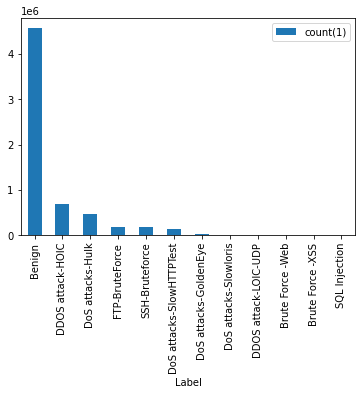

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
pandas_df = sqlDF.toPandas()
pandas_df.sort_values(by='count(1)',ascending=False).plot(x ='Label', y='count(1)', kind = 'bar')


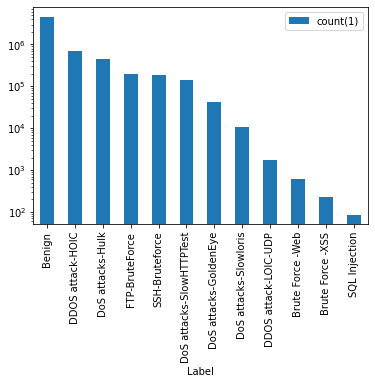

In [ ]:
pandas_df.sort_values(by='count(1)',ascending=False).plot(x ='Label', y='count(1)', kind = 'bar', logy=True)

# **SQL Windows quires**

In [ ]:
type(bdsql)

pyspark.sql.dataframe.DataFrame

In [ ]:
bdsql.show(2)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+------------+-------------+--------------+------------+------------+-----------+------------+--------------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+

In [ ]:
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import unix_timestamp
df_conv=bdsql.withColumn("Timestamp",unix_timestamp("Timestamp", 'dd/MM/yyyy HH:mm:ss').cast(TimestampType()))
df_conv.printSchema()
df_conv.show(5)

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Flow Duration: long (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: integer (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: long (nullable = true)
 |-- Flow IAT Min: long (nullable = true)

In [ ]:
df_conv.show(5)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+--------------+------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-

In [ ]:
stopping

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="labelIndex",featuresCol="features",smoothing=1.0,modelType="multinomial")
model = nb.fit(train_data)
predictions = model.transform(test_data)
predictions.select("labelIndex","features","probability", "prediction").show(4)

In [ ]:
import pyspark.sql.functions as F
check = predictions.withColumn('correct', F.when(F.col('labelIndex') == F.col('prediction'),1).otherwise(0))
check.groupby("correct").count().show()
evaluator =MulticlassClassificationEvaluator(labelCol="labelIndex",predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy = " + str(accuracy))
accuracy = evaluator.evaluate(predictions)
print("accuracy =", accuracy)
print("Test Error = %g " % (1.0 - accuracy)) 
print(model)


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier

(trainingData, testData) = newdf.randomSplit([0.7, 0.3])

gbt = GBTClassifier(labelCol='labelIndex', featuresCol='features',maxIter=10)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

predictions.select("prediction", 'Label', "features").show(5)

evaluator = MulticlassClassificationEvaluator(labelCol='Label', predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy =", accuracy)
print("Test Error = %g" % (1.0 - accuracy))
gbtModel = model.stages[2]
print(gbtModel)  # summary only

IllegalArgumentException: ignored

In [ ]:
predictions = LR_model.transform(test_data)

In [ ]:
# inspect F1 and accuracy scores
print('Logistic Regression F1 Score:',evaluator.evaluate(predictions,{evaluator.metricName: 'f1'}))
print('Logistic Regression model Accuracy:',evaluator.evaluate(predictions,{evaluator.metricName: 'accuracy'}))

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='labelIndex',maxIter=15)
GBT_Model = gbt.fit(train_data)
gbt_predictions = GBT_Model.transform(test_data)


Py4JJavaError: ignored

In [ ]:
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="Label", outputCol="labelIndex")
newdf = l_indexer.fit(bddata).transform(bddata)
newdf.show(4)

In [ ]:
newdf=newdf.drop('Label')

newdf.show(4)

In [ ]:
newdf.dtypes

In [ ]:
num_cols_NewDF = [item[0] for item in newdf.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(num_cols_NewDF)) + '  numerical features')

In [ ]:
import six

for i in newdf.select(num_cols_NewDF).columns:
    if not( isinstance(newdf.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Label for ", i, newdf.stat.corr('labelIndex',i))

In [ ]:
train, test = newdf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'], outputCol = 'features')
vdf = vectorAssembler.transform(newdf)
vdf = vdf.select(['features', 'labelIndex'])
vdf.show(4)

In [ ]:
trainingset, testingset = vdf.randomSplit([0.7, 0.3], seed = 2018)

In [ ]:
(trainingData, testData) = vdf.randomSplit([0.7, 0.3])
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")
model = dt.fit(trainingData)

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
STOP HERE

In [ ]:
assemblerInputs = num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(newdf)
df = pipelineModel.transform(newdf)
cols = newdf.columns
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

In [ ]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert #aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector #and the rest of numerical features into a 
# single vector column. we append every step of the process in a #stages array
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [ ]:
from pyspark.ml import Pipeline
cols = data.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
new_df = pipelineModel.transform(data)

In [ ]:
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)

In [ ]:
# New dataset after feature engineering:

import pandas as pd
pd.DataFrame(new_df.take(2), columns=new_df.columns)

In [ ]:
data.groupby('Label').count().toPandas()

In [ ]:

data.printSchema()

In [ ]:

data.dtypes

In [ ]:
# split the data into trainign and testin sets
train, test = new_df.randomSplit([0.80, 0.20], seed = 43)
#print(train.count())
#print(test.count())

# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'Label', maxIter=15)
LR_model = LR.fit(train)

In [ ]:
data.columns

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'], outputCol = 'features')
vdf = vectorAssembler.transform(data)
vdf = vdf.select(['features', 'Label'])
vdf.show(4)
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="Label", outputCol="labelIndex")
vdf = l_indexer.fit(vdf).transform(vdf)
vdf.show(4)
#vdf.agg(countDistinct(col("labelIndex")).alias("count")).show()


In [ ]:
vdf.groupBy("labelIndex").count().show()

In [ ]:
vdf.dtypes

In [ ]:
vdf= vdf.drop('Label')

In [ ]:
vdf.dtypes

In [ ]:
vdf.show(4)

In [ ]:
(trainingData, testData) = vdf.randomSplit([0.7, 0.25])

In [ ]:
# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'labelIndex', maxIter=15)
LR_model = LR.fit(trainingData)

In [ ]:
from pyspark.sql.functions import col, countDistinct

vdf.agg(countDistinct(col("labelIndex")).alias("count")).show()
vdf.groupBy("labelIndex").count().show()

# **iris data set practise for NaiveBayes model**

In [ ]:
df = spark.read.csv("/content/iris.data", inferSchema=True)\
.toDF("sep_len", "sep_wid", "pet_len", "pet_wid", "label")

In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
df.show(2)

+-------+-------+-------+-------+-----------+
|sep_len|sep_wid|pet_len|pet_wid|      label|
+-------+-------+-------+-------+-----------+
|    5.1|    3.5|    1.4|    0.2|Iris-setosa|
|    4.9|    3.0|    1.4|    0.2|Iris-setosa|
+-------+-------+-------+-------+-----------+
only showing top 2 rows



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
vector_assembler = VectorAssembler(\
inputCols=["sep_len", "sep_wid", "pet_len", "pet_wid"],\
outputCol="features")
df_temp = vector_assembler.transform(df)
df_temp.show(3)

+-------+-------+-------+-------+-----------+-----------------+
|sep_len|sep_wid|pet_len|pet_wid|      label|         features|
+-------+-------+-------+-------+-----------+-----------------+
|    5.1|    3.5|    1.4|    0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|    4.9|    3.0|    1.4|    0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|    4.7|    3.2|    1.3|    0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
+-------+-------+-------+-------+-----------+-----------------+
only showing top 3 rows



In [ ]:
type(df_temp)

pyspark.sql.dataframe.DataFrame

In [ ]:
df = df_temp.drop('sep_len', 'sep_wid', 'pet_len', 'pet_wid')
df.show(3)

+-----------+-----------------+
|      label|         features|
+-----------+-----------------+
|Iris-setosa|[5.1,3.5,1.4,0.2]|
|Iris-setosa|[4.9,3.0,1.4,0.2]|
|Iris-setosa|[4.7,3.2,1.3,0.2]|
+-----------+-----------------+
only showing top 3 rows



In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
from pyspark.ml.feature import StringIndexer
l_indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
df = l_indexer.fit(df).transform(df)

In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
df.show(3)

+-----------+-----------------+----------+
|      label|         features|labelIndex|
+-----------+-----------------+----------+
|Iris-setosa|[5.1,3.5,1.4,0.2]|       0.0|
|Iris-setosa|[4.9,3.0,1.4,0.2]|       0.0|
|Iris-setosa|[4.7,3.2,1.3,0.2]|       0.0|
+-----------+-----------------+----------+
only showing top 3 rows



In [ ]:
splits = df.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="labelIndex",\
featuresCol="features", smoothing=1.0,\
modelType="multinomial")
model = nb.fit(train)

In [ ]:
predictions = model.transform(test)
predictions.select("label", "labelIndex", 
"probability", "prediction").show(5)

+-----------+----------+--------------------+----------+
|      label|labelIndex|         probability|prediction|
+-----------+----------+--------------------+----------+
|Iris-setosa|       0.0|[0.73502886090153...|       0.0|
|Iris-setosa|       0.0|[0.64985557718392...|       0.0|
|Iris-setosa|       0.0|[0.55508830217120...|       0.0|
|Iris-setosa|       0.0|[0.71765512033989...|       0.0|
|Iris-setosa|       0.0|[0.66081341393231...|       0.0|
+-----------+----------+--------------------+----------+
only showing top 5 rows



In [ ]:
evaluator =\
MulticlassClassificationEvaluator(labelCol="labelIndex",\
predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.9682539682539683


In [ ]:
bddata.show(4)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----

In [ ]:
nvdata.show(4)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+------------+-------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+---------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----

In [ ]:
nvdata.columns

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'], outputCol = 'features')


In [ ]:
vdf = vectorAssembler.transform(nvdata)
vdf = vdf.select(['features', 'labelIndex'])
vdf.show(4)

+--------------------+----------+
|            features|labelIndex|
+--------------------+----------+
|(77,[2,3,15,16,17...|       0.0|
|(77,[2,3,15,16,17...|       0.0|
|(77,[2,3,15,16,17...|       0.0|
|(77,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 4 rows



In [ ]:
splits = vdf.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="labelIndex",\
featuresCol="features", smoothing=1.0,\
modelType="multinomial")
model = nb.fit(train)

Py4JJavaError: ignored

In [ ]:


#Need to find which day has more attacks happen

#sqlDF = spark.sql("SELECT Label,weekofyear,Day, count(*) FROM trView GROUP BY Day,weekofyear,Label").show(100)

#ORDER BY ASC





df_conv.groupBy("Label").pivot("Day").count().orderBy("Label",ascending=False).show(100,False)

q1=spark.sql("select Label,count(*) as count FROM trView where Day==14 group by Label having count>10").show()
